#### <strong>第四次作品：卷積神經網路CNN與人臉影像辨識</strong>
學號：711233115

姓名：許政揚
<hr>

 <font color=skyblue>作品目標</font>：
 
本作品將展示如何將耶魯人臉的影像資料應用於 CNN 卷積神經網路的預測模型中。其中又包括如何將資料轉換成能夠放入 PyTorch 的型態以及卷積神經網路中各層的功能、資料通過的大小等。
最後會使用模型對人臉資料進行預測，觀察是否能夠正確將影像分類至相對應的人臉標籤中。

<hr>

#### <strong><font color=dodgerblue>匯入人臉資料：</font></strong> 

這段程式碼將從.mat檔中載入人臉圖像數據，數據保存在X中，每列代表一張圖像。 
nfaces 陣列包含每個人的圖像數量，程式碼透過遍歷nfaces來產生對應的標籤陣列 y，其中 y 的每個元素代表對應圖像的標籤。

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.io

# 設定隨機種子
np.random.seed(0)

def show_montage(X, n, m, h, w):
    '''
    X: 影像資料矩陣，每行代表一張影像
    n, m: 每張影像的大小 n x m
    h, w: 建立一個蒙太奇圖陣，大小為 h x w
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# 載入數據
D = scipy.io.loadmat('/Users/andrewhsu/Library/Mobile Documents/com~apple~CloudDocs/VsCode_python/mat/allFaces.mat')
X = D['faces'].T # 32256 x 2410，每列代表一張影像
nfaces = np.ndarray.flatten(D['nfaces'])  # 確認這裡載入的是正確的標籤數據

n_persons = D['person'].item()
X.shape # 32256 x 2410
nfaces.shape # 2410
len(nfaces)

y = np.zeros(X.shape[0])
start_idx = 0
for i in range(len(nfaces)):
    end_idx = start_idx + nfaces[i]
    y[start_idx:end_idx] = i
    start_idx = end_idx

#### <strong><font color=dodgerblue>顯示部分資料：</font></strong> 

此段程式碼目的是將只頂第幾個人的所有圖像以蒙太奇的形式顯示出來，這樣可以直觀地查看該人的多張人臉圖像。
以下呈現的為第 38 個人的人臉資料，顯示 60 張並以 6*10 的大小呈現。

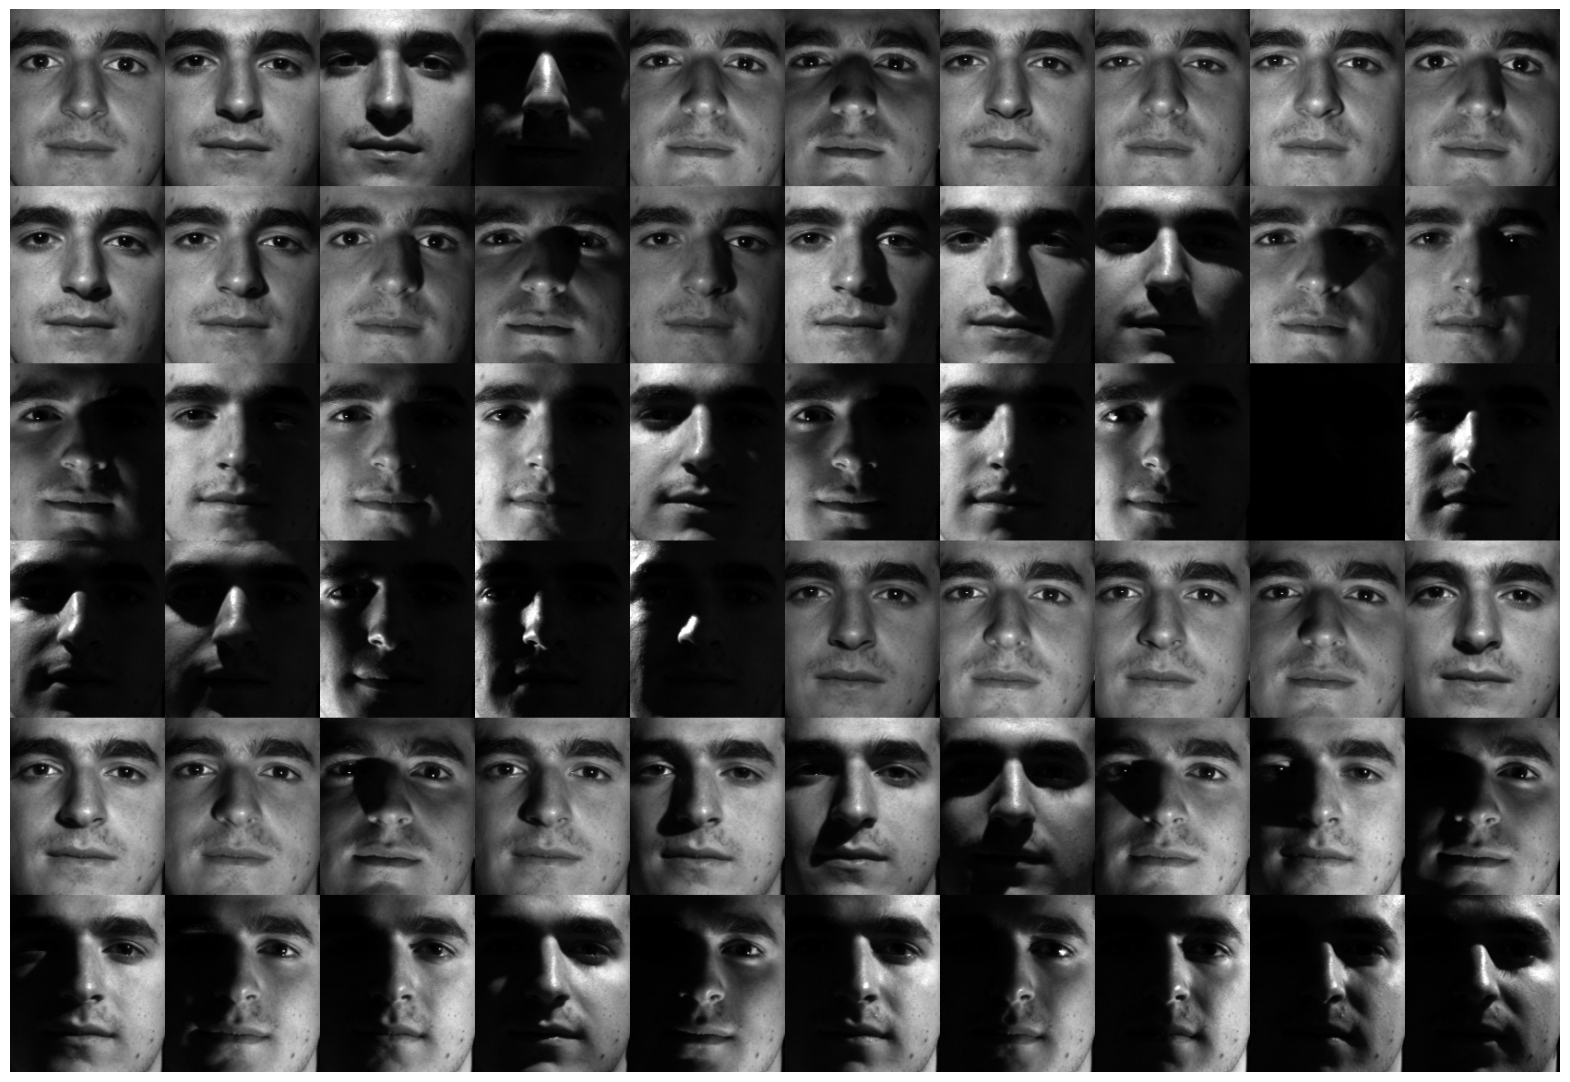

In [29]:
import matplotlib.pyplot as plt


def show_person_faces(person_idx, X, n, m):
    person_idx = person_idx - 1
    subset = X[:, sum(nfaces[:person_idx]):sum(nfaces[:(person_idx + 1)])]
    allFaces = np.zeros((n * 6, m * 10))
    count = 0

    for j in range(6):
        for k in range(10):
            if count < nfaces[person_idx]:
                allFaces[j * n:(j + 1) * n, k * m:(k + 1) * m] = np.reshape(subset[:, count], (m, n)).T
                count += 1

    fig, ax = plt.subplots(figsize=(20, 15))
    plt.imshow(allFaces, cmap='gray')
    plt.axis('off')
    plt.show()

m = int(D['m']) # 168
n = int(D['n']) # 192
show_person_faces(38, X.T, n, m)

#### <strong><font color=dodgerblue>確認 y 的長度是否與 X 的樣本數量一致：</font></strong> 

此程式碼的作用是檢查樣本資料 X 和標籤資料 y 是否有相同數量的樣本。如果樣本數量不一致，則會顯示一個帶有錯誤訊息的 AssertionError

In [3]:
assert X.shape[0] == y.shape[0], f"X has {X.shape[0]} samples but y has {y.shape[0]} labels"

#### <strong><font color=dodgerblue>將數據分割為訓練集和測試集：</font></strong> 

訓練資料與測試資料切割比例為 8:2 。

In [4]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

#### <strong><font color=dodgerblue>準備資料: 轉換為 Tensor 型態的過程</font></strong> 

以下程式碼的目的是確保資料可以有效地輸入到 PyTorch 模型中進行訓練和測試。

因此會先將 NumPy 陣列轉換為 Tensor型態。
其中 .float() 將資料類型轉換為 32 位元浮點數，這是大多數神經網路模型所需的資料類型。 .long() 將標籤轉換為長整型，這是 PyTorch 中分類任務的標準標籤類型。

建立 TensorDataset 會將將特徵和標籤配對在一起，再建立一個可用於 DataLoader 的資料集。
DataLoader 以 128 個樣本為一個批次分批載入數據，並進行隨機輸入訓練集以提高訓練效果。

In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 標準化數據
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 調整數據形狀
X_train = X_train.reshape(-1, 1, 168, 192)  
X_test = X_test.reshape(-1, 1, 168, 192)  
#X_train = np.transpose(X_train,(0, 1, 3, 2))  
#X_test = np.transpose(X_test,(0, 1, 3, 2)) 

# 將數據轉換為 PyTorch 張量
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# 創建數據集和數據加載器
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#### <strong><font color=dodgerblue>定義卷積神經網路 CNN</font></strong> 

- <font color=forestgreen>卷積層（Convolutional Layer）</font>

透過卷積核在輸入資料上滑動並進行點積運算，提取輸入資料的局部特徵。捕捉影像中的邊緣、紋理、形狀等局部資訊。

第一層卷積層 conv1 的輸入通道為 1（灰階影像），輸出通道為 8，卷積核大小為 5x5，並在周圍填入 2。第二層 con2 的輸入通道為 8 ，輸出通道為 16，卷積核大小則為 3x3 並在周圍補上 1。
最後延伸至第四層con4 的輸入通道為 32 ，輸出通道為 32，卷積核大小則為 3x3 並也在周圍補上 1。


- <font color=forestgreen>批次歸一化層（Batch Normalization Layer）</font>

批量歸一化層在每個小批次的資料上執行常態化操作，使其具有零均值和單位方差，並引入兩個可訓練參數來恢復資料的分佈。

其中 batch_norm1 即對 conv1 的輸出進行批次常態化。batch_norm2 、 batch_norm3 、batch_norm4 則依此類推，對不同的卷積層進行常態化。

- <font color=forestgreen>全連接層（Fully Connected Layer）</font>

全連接層對輸入資料進行線性變換，將輸入的多維資料展平並對應到輸出空間。它主要用於將卷積層提取的特徵映射到最終的分類或回歸結果。

其中 fc1 輸入尺寸為 32 * 12 * 42，輸出尺寸為256。batch_norm_fc1 則將 fc1 的輸出進行批次常態化。
接著 fc2 輸入尺寸為256，輸出尺寸為64。batch_norm_fc2 則將 fc2 的輸出進行批次常態化。
最後 fc3 輸入尺寸為64，輸出尺寸為38，並對應38個不同類別的人臉圖像。

- <font color=forestgreen>前向傳播（forward pass）</font>

在前向傳播過程中，輸入資料依序通過多個卷積層、批次歸一化層、ReLU激活函數和最大池化層。具體步驟如下：

輸入資料先透過第一個卷積層和ReLU激活函數，增加非線性，然後經過批量歸一化層穩定訓練過程。接著，資料通過2x2的最大池化層，減少特徵圖尺寸。
這個過程在接下來的捲積層中重複，共有四個卷積層，每個卷積層後面都跟著ReLU活化、批量歸一化和最大池化層。
卷積和池化後的輸出被展平成一維向量，並輸入全連接層。
資料依序通過兩個全連接層，每個全連接層後面都包含ReLU激活和批量歸一化層。
最後，資料經過第三個全連接層，輸出最終的分類結果。
這一系列操作逐步提取輸入資料的特徵，完成分類任務。

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)  
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(32)
        
        # 改变全连接层的节点数量
        self.fc1 = nn.Linear(32 * 12 * 42, 256)  
        self.batch_norm_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)  
        self.batch_norm_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 38)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        x = F.relu(self.conv4(x))
        x = self.batch_norm4(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.batch_norm_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm_fc2(x)
        x = self.fc3(x)
        return x

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)

# Print model summary
summary(net, input_size=(1, 168, 192))

Using cpu device
Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16128, out_features=256, bias=True)
  (batch_norm_fc1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (batch_norm_fc2): BatchNorm1d(64, eps=1e-05, momentum=0.1,

#### <strong><font color=dodgerblue>利用 torch summary 觀察模型結構</font></strong>

輸入模型的形狀 (1, 168, 192)，對應單通道、高度為168、寬度為192的影像。
這段程式碼用於總結和檢查模型的結構，幫助驗證模型的正確性，並確保輸入和輸出形狀符合預期。

In [7]:
from torchsummary import summary

summary(net, input_size=(1, 168, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 168, 192]             208
       BatchNorm2d-2          [-1, 8, 168, 192]              16
            Conv2d-3           [-1, 16, 84, 96]           1,168
       BatchNorm2d-4           [-1, 16, 84, 96]              32
            Conv2d-5           [-1, 32, 42, 48]           4,640
       BatchNorm2d-6           [-1, 32, 42, 48]              64
            Conv2d-7           [-1, 32, 42, 48]           9,248
       BatchNorm2d-8           [-1, 32, 42, 48]              64
            Linear-9                  [-1, 256]       4,129,024
      BatchNorm1d-10                  [-1, 256]             512
           Linear-11                   [-1, 64]          16,448
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                   [-1, 38]           2,470
Total params: 4,164,022
Trainable param

#### <strong><font color=dodgerblue>定義損失函數與優化器</font></strong>

定義了損失函數criterion，這裡使用的是交叉熵損失（CrossEntropyLoss），通常用於多分類任務。交叉熵損失計算模型預測與實際標籤之間的差異，並為模型參數提供梯度資訊。

同時也定義了優化器optimizer，使用的是隨機梯度下降（SGD）優化器。 net.parameters()提供了模型的所有參數，lr=0.001設定了學習率（learning rate），momentum=0.9設定了動量參數（momentum），用來加速收斂並減少振盪。

In [8]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 

#### <strong><font color=dodgerblue>訓練模型</font></strong>




這段程式碼實現了一個神經網路的訓練循環，包含15個epoch，每個epoch遍歷所有訓練資料。在每個批次中，資料被移到裝置（GPU或CPU），然後透過網路進行前向傳播，計算損失，執行反向傳播以計算梯度，最後更新模型參數。代碼定期列印每200個批次的平均損失，並在每個epoch結束時列印該epoch的平均損失。

In [9]:
epochs = 15
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
    # Calculate and print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.3f}')

print('Finished Training')

Epoch [1/15], Train Loss: 3.209
Epoch [2/15], Train Loss: 2.240
Epoch [3/15], Train Loss: 1.783
Epoch [4/15], Train Loss: 1.497
Epoch [5/15], Train Loss: 1.259
Epoch [6/15], Train Loss: 1.097
Epoch [7/15], Train Loss: 0.944
Epoch [8/15], Train Loss: 0.808
Epoch [9/15], Train Loss: 0.687
Epoch [10/15], Train Loss: 0.606
Epoch [11/15], Train Loss: 0.541
Epoch [12/15], Train Loss: 0.519
Epoch [13/15], Train Loss: 0.446
Epoch [14/15], Train Loss: 0.395
Epoch [15/15], Train Loss: 0.403
Finished Training


#### <strong><font color=dodgerblue>儲存模型</font></strong>

將模型儲存為一 .pt檔做為再次訓練的起點或訓練完成後的使用狀態。

In [10]:
PATH = '/Users/andrewhsu/Library/Mobile Documents/com~apple~CloudDocs/VsCode_python/SHALLOW_ML/YaleFaces_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

#### <strong><font color=dodgerblue>測試模型</font></strong>


這段程式碼在測試集上評估神經網路的準確率。透過停用梯度計算並遍歷測試數據，將每批數據傳輸到指定設備，進行前向傳播以取得預測結果。隨後統計預測正確的樣本數量，並計算整體準確率，最後輸出網路在測試集上的準確率。

模型準確率為 93%。

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')


Accuracy of the network on the 482 test images: 93 %


#### <strong><font color=dodgerblue>使用模型進行預測</font></strong>

以下程式碼用來展示神經網路在一批測試資料上的預測結果。
首先載入了一批測試數據，然後將這些數據傳遞給經過訓練的神經網路進行預測。接著，它透過循環遍歷每張圖像，將其顯示在子圖中，並在每個子圖的標題中顯示真實標籤和預測標籤。此外，它計算了整個批次的準確率，並輸出該準確率。可以觀察到張人臉輸入模型後，幾乎都正確預測至所屬的編號中。

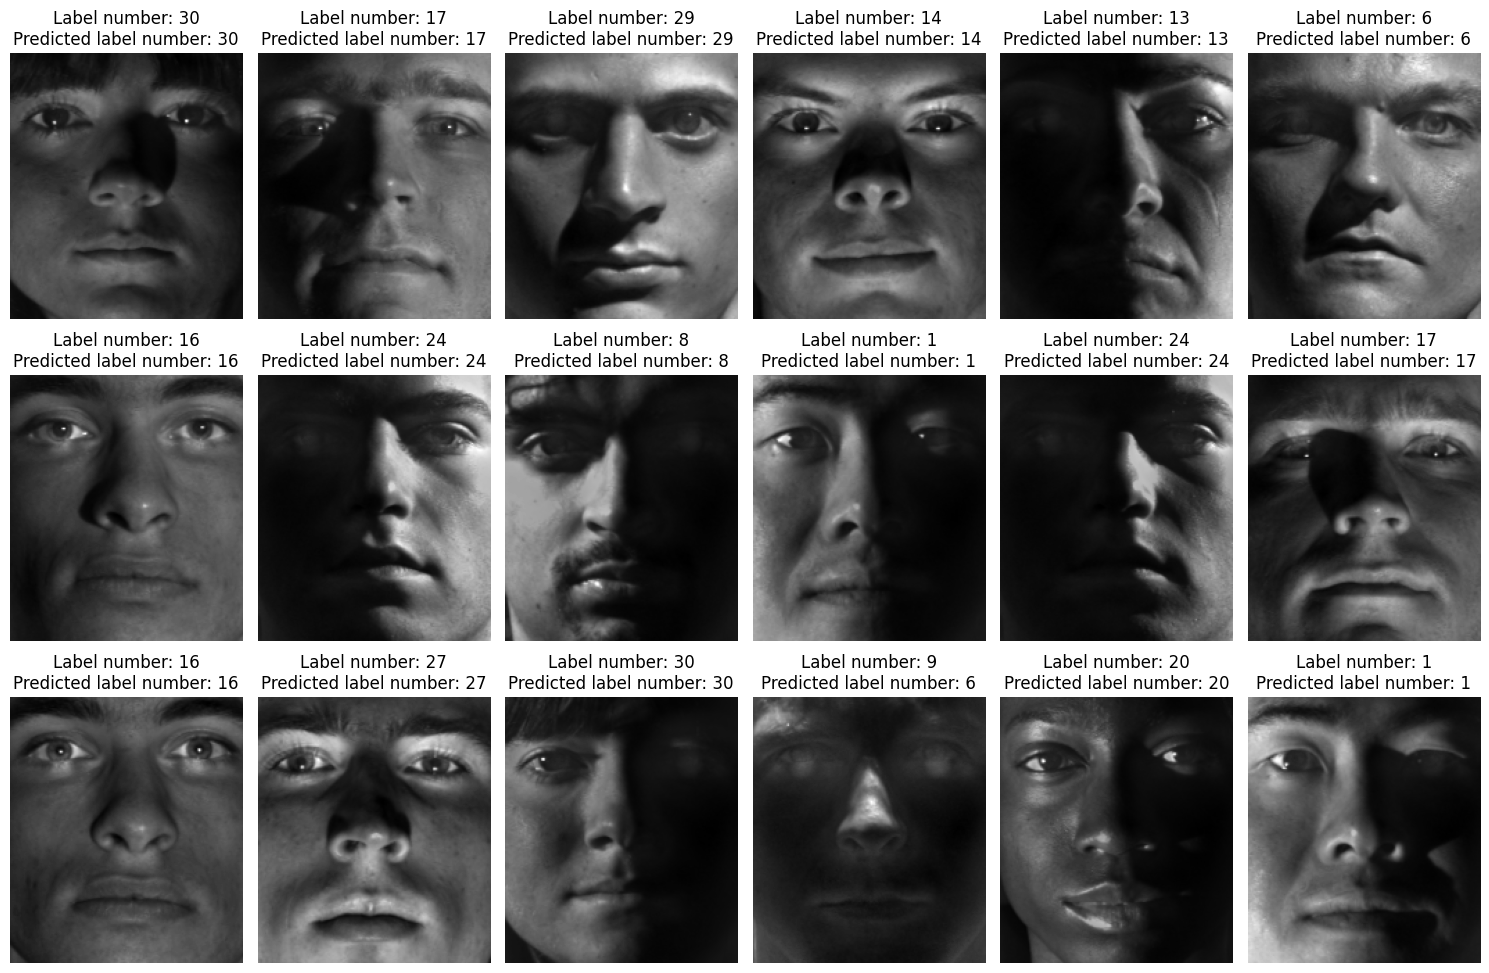

Accuracy of batch: 89.84%


In [13]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

net.eval()
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 6, figsize=(15, 10))
axes = axes.ravel()

for i in range(len(images)):
    if i >= len(axes):
        break

    image = images[i].cpu().numpy().squeeze()
    label = labels[i].cpu().numpy()
    pred = predicted[i].cpu().numpy()

    # 顺时针旋转图像 90 度
    image_rotated = np.rot90(image, -1)

    axes[i].imshow(image_rotated, cmap='gray')
    axes[i].set_title(f"Label number: {label}\nPredicted label number: {pred}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

correct = (predicted == labels).sum().item()
accuracy = correct / len(images) * 100
print(f"Accuracy of batch: {accuracy:.2f}%")

#### <strong><font color=dodgerblue>讀入已訓練之模型進行預測</font></strong>

以下程式碼將讀入訓練好之模型.pt檔，並輸入其中一張耶魯人臉圖像，觀察模型會將其預測成哪張人臉圖像。以下範例中選擇放入第38個人的第一張影像，可以看到模型將其預測成第33個人的影像。

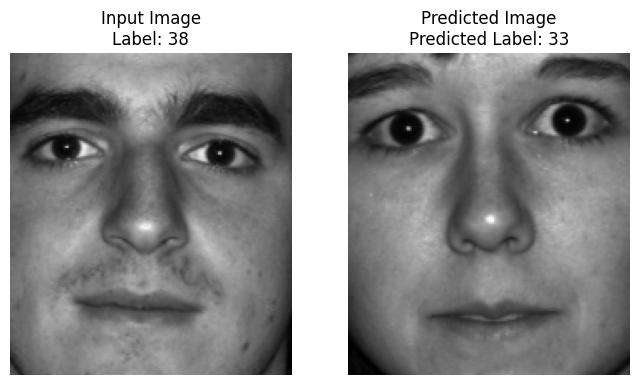

In [28]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
import torchvision.transforms as transforms

    
# 初始化模型
net = Net().to(device)

# 定義預訓練模型的路徑
PATH = '/Users/andrewhsu/Library/Mobile Documents/com~apple~CloudDocs/VsCode_python/SHALLOW_ML/YaleFaces_net.pt'

# 加載狀態字典
net.load_state_dict(torch.load(PATH))


# 將模型設定為評估模式
net.eval()

# 從資料集中選取一張圖像進行預測
def select_image_from_dataset(person_idx, img_idx, X, n, m):
    person_idx = person_idx - 1
    subset = X[:, sum(nfaces[:person_idx]):sum(nfaces[:(person_idx + 1)])]
    image = np.reshape(subset[:, img_idx], (m, n)).T
    return image

# 選擇第38個人的第1張圖像
#m = int(D['m'])  # 168
#n = int(D['n'])  # 192
input_image = select_image_from_dataset(38, 0, X.T, n, m)

# 將圖像轉換為Tensor並預處理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(input_image).unsqueeze(0).to(device)  # 增加batch維度

# 使用模型進行預測
with torch.no_grad():
    output = net(image_tensor)
    _, predicted = torch.max(output, 1)

# 獲取預測結果
pred_label = predicted.item()

# 從資料集中選擇預測標籤對應的第一張圖像
predicted_image = select_image_from_dataset(pred_label + 1, 0, X.T, n, m)

# 顯示輸入圖像和預測結果對應的圖像
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].imshow(input_image, cmap='gray')
axes[0].set_title(f"Input Image\nLabel: 38")
axes[0].axis('off')

axes[1].imshow(predicted_image, cmap='gray')
axes[1].set_title(f"Predicted Image\nPredicted Label: {pred_label + 1}")
axes[1].axis('off')

plt.show()